# Transcription from unspecific binding of RNAP within the coding region.

In [1]:
using CSV, wgregseq, CairoMakie, DataFrames, Statistics

wgregseq.plotting_style.default_makie!()

Import energy matrix for RNAP.

In [2]:
rnap_emat = CSV.read("rnap.txt", DataFrame, delim=" ", header=["A", "C", "G", "T"])
first(rnap_emat, 5)

,A,C,G,T
,Float64,Float64,Float64,Float64
1,-0.313427,-0.198978,-0.291059,-0.237371
2,-0.280792,-0.0924429,-0.313427,-0.11777
3,-0.15885,-0.196853,-0.212634,-0.313427
4,-0.313427,-0.179702,-0.312079,-0.184001
5,0.0651327,-0.133555,-0.313427,0.495313


Sequence for riboJ::sfYFP.

In [3]:
ribo_yfp = "GGGCCCagctgtcaccggatgtgctttccggtctgatgagtccgtgaggacgaaacagcctctacaaattttgtttaatactagaatctcatagatcaaatataggggggattactagATGCGTAAAGGCGAAGAGCTGTTCACTGGTTTCGTCACTATTCTGGTGGAACTGGATGGTGATGTCAACGGTCATAAGTTTTCCGTGCGTGGCGAGGGTGAAGGTGACGCAACTAATGGTAAACTGACGCTGAAGTTCATCTGTACTACTGGTAAACTGCCGGTACCTTGGCCGACTCTGGTAACGACGCTGACTTATGGTGTTCAGTGCTTTGCTCGTTATCCGGACCACATGAAGCAGCATGACTTCTTCAAGTCCGCCATGCCGGAAGGCTATGTGCAGGAACGCACGATTTCCTTTAAGGATGACGGCACGTACAAAACGCGTGCGGAAGTGAAATTTGAAGGCGATACCCTGGTAAACCGCATTGAGCTGAAAGGCATTGACTTTAAAGAAGACGGCAATATCCTGGGCCATAAGCTGGAATACAATTTTAACAGCCACAATGTTTACATCACCGCCGATAAACAAAAAAATGGCATTAAAGCGAATTTTAAAATTCGCCACAACGTGGAGGATGGCAGCGTGCAGCTGGCTGATCACTACCAGCAAAACACTCCAATCGGTGATGGTCCTGTTCTGCTGCCAGACAATCACTATCTGAGCACGCAAAGCGTTCTGTCTAAAGATCCGAACGAGAAACGCGATCACATGGTTCTGCTGGAGTTCGTAACCGCAGCGGGCATCACGCATGGTATGGATGAACTGTACAAATAA" |> uppercase

"GGGCCCAGCTGTCACCGGATGTGCTTTCCGGTCTGATGAGTCCGTGAGGACGAAACAGCCTCTACAAATTTTGTTTAATACTAGAATCTCATAGATCAAATATAGGGGGGATTACTAGATGCGTAAAGGCGAAGAGCTGTTCACTGGTTTCGTCACTATTCTGGTGGAACTGGATGGTGATGTCAACGGTCATAAGTTTTCCGTGCGTGGCGAGGGTGAAGGTGACGCAACTAATGGTAAACTGACGCTGAAGTTCATCTGTACTACTGGT" ⋯ 294 bytes ⋯ "GTTTACATCACCGCCGATAAACAAAAAAATGGCATTAAAGCGAATTTTAAAATTCGCCACAACGTGGAGGATGGCAGCGTGCAGCTGGCTGATCACTACCAGCAAAACACTCCAATCGGTGATGGTCCTGTTCTGCTGCCAGACAATCACTATCTGAGCACGCAAAGCGTTCTGTCTAAAGATCCGAACGAGAAACGCGATCACATGGTTCTGCTGGAGTTCGTAACCGCAGCGGGCATCACGCATGGTATGGATGAACTGTACAAATAA"

Plot the binding energy across the sequence.

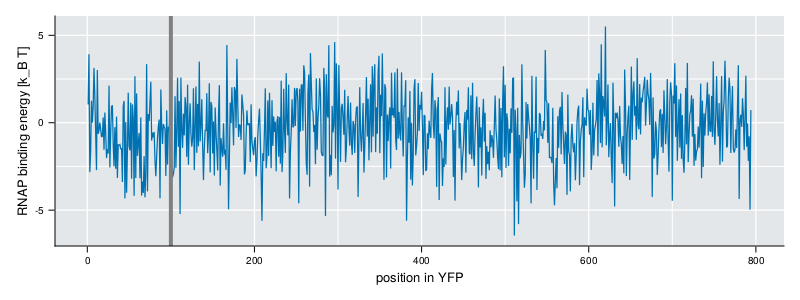

In [34]:
energies = [sum([rnap_emat[i, Symbol(x)] for (i, x) in enumerate(ribo_yfp[j:j+40] |> collect)])  for j in 1:length(ribo_yfp)-41]
#last_transcribed = length(ribo_yfp) - 163 - 41
last_transcribed = 100

fig = Figure(resolution=(800, 300))
ax = Axis(fig[1, 1])
ax.ylabel = "RNAP binding energy [k_B T]"
ax.xlabel = "position in YFP"
lines!(ax, energies)
vlines!(ax, last_transcribed, color="gray", linewidth=4)
fig

Compute binding energy of RNAP to lacUV5.

In [35]:
lacUV5 = "TCGAGTTTACACTTTATGCTTCCGGCTCGTATAATGTGTGG"
lacUV5_energy = sum([rnap_emat[i, Symbol(x)] for (i, x) in enumerate(lacUV5 |> collect)])

-6.992057747845055

Compute part of partition function that relates to unspecific binding of 

In [36]:
N_NS = 4.5 * 10^6
P = 1000

Z_off_target(R, eps) = (1 + R/N_NS * exp(-eps)) * P/N_NS * sum(exp.([-sum([rnap_emat[i, Symbol(x)] for (i, x) in enumerate(ribo_yfp[j:j+40] |> collect)])  for j in 1:last_transcribed]))

Z_P = P / N_NS * exp(-lacUV5_energy)

0.24176842609795707

In [37]:
fold_change(R, eps_R) = (1 + Z_P) / (1 + Z_P + R / N_NS * exp(-eps_R))
fold_change_off(R, eps_R) = (1 + Z_P + Z_off_target(R, eps_R)) / (1 + Z_P + Z_off_target(R, eps_R) + R / N_NS * exp(-eps_R))

fold_change_off (generic function with 1 method)

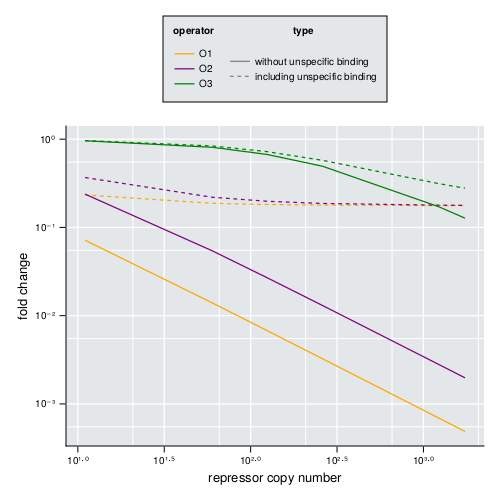

In [38]:
R = [11, 60, 124, 260, 1220, 1740]

fig = Figure(resolution=(500, 500))
ax = Axis(fig[2, 1], xscale=log10, yscale=log10)
ax.xlabel = "repressor copy number"
ax.ylabel = "fold change"

for (eps, color, label) in zip([-15.7, -14.3, -10], ["orange", "purple", "green"], ["O1", "O2", "O3"])
    lines!(ax, R, [fold_change.(r, eps) for r in R], color = color)
    lines!(ax, R, [fold_change_off.(r, eps) for r in R], linestyle=:dash, color=color)
end


markersizes = [5, 10, 15, 20]
colors = [:red, :green, :blue, :orange]

color_legend = [LineElement(color = color) for color in ["orange", "purple", "green"]]

style_legend = [LineElement(color="gray", linestyle=style) for style in [:solid, :dash]]

legend = Legend(fig,
    [color_legend, style_legend],
    [["O1", "O2", "O3"], ["without unspecific binding", "including unspecific binding"]], 
    ["operator", "type"])
legend.orientation = :horizontal
legend.nbanks = 3
fig[1, 1] = legend

fig